# **Regression DNN Model**



In [ ]:
pip install -U keras-tuner

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import reciprocal, norm

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

import seaborn as sns
from numpy.random import seed

import tensorflow.keras as keras
import tensorflow as tf
print(tf.__version__)

from kerastuner import HyperModel, HyperParameters
from kerastuner.tuners import RandomSearch

2.4.1


In [5]:
data = pd. read_csv('train_wells_20210131_cln_bal.csv')
data=data[(data.DTCO<140) & (data.DTSM<240)]
data.describe()

,Depth,DTSM,DTCO,GAMMA,RHO
count,150625.000000,150625.000000,150625.000000,150625.000000,150625.000000
mean,8079.579824,132.023715,71.270285,82.517627,2.553487
std,3938.882276,34.998677,15.438664,44.815089,0.182163
min,559.000000,72.470100,40.459400,0.731000,1.223200
25%,5053.000000,104.310400,58.843400,46.972900,2.466800
50%,7877.000000,123.750900,70.195100,88.414200,2.589800
75%,11178.500000,151.105300,82.471600,111.434900,2.663100
max,18739.500000,239.998200,122.186300,623.161700,3.091600


In [6]:
cols=['GAMMA','RHO','DTCO']
#X = data[cols]
X = data[['Depth']+cols]
Y = data[['DTSM']]

In [7]:
seed(42)
X_train0, X_test0, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [8]:
X_train = X_train0[cols]
X_test = X_test0[cols]

depth_train = X_train0['Depth']
depth_test = X_test0['Depth']

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(135562, 3) (135562, 1)
(15063, 3) (15063, 1)


In [9]:
scaler_x = preprocessing.StandardScaler().fit(X_train)
X_train_sc = pd.DataFrame(scaler_x.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_sc = pd.DataFrame(scaler_x.transform(X_test), columns=X_test.columns, index=X_test.index)

## Linear regression with neural network



In [8]:
def build_model(n_layer=2, n_neuron=4, learning_rate=1e-3, input_shape=X_train_sc.shape[1]):
  model = keras.models.Sequential()
  model.add(keras.layers.InputLayer(input_shape=input_shape))
  for layer in range(n_layer):
    model.add(keras.layers.Dense(n_neuron, activation='relu'))
  keras.layers.Dense(1)

  optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(loss='mse', optimizer=optimizer)

  return model

In [11]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

hparams = {
    "n_layer": [2,3],
    "n_neuron": np.arange(4,17,4).tolist(),
    "learning_rate": reciprocal(3e-3, 3e-2).rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, hparams, n_iter=10, cv=3)

start = datetime.now()
rnd_search_cv.fit(X_train_sc, 
                  Y_train, 
                  epochs=25,
                  batch_size=128,
                  validation_split=0.1,
                  verbose=0,
                  callbacks=[keras.callbacks.EarlyStopping(patience=5)]	
) 


print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)
print('runtime:{}'.format(datetime.now()-start))

1413/1413 [==============================] - 2s 2ms/step - loss: 2455.3806
{'n_neuron': 8, 'n_layer': 2, 'learning_rate': 0.0037959009758986055}
-139.10640970865884
runtime:0:14:40.085165


In [12]:
rscv_results = pd.DataFrame(rnd_search_cv.cv_results_)[['mean_fit_time',	'mean_score_time',	'param_n_neuron',	'param_n_layer', 'param_learning_rate', 'mean_test_score', 'std_test_score', 'rank_test_score']]
rscv_results.sort_values(by='rank_test_score')

,mean_fit_time,mean_score_time,param_n_neuron,param_n_layer,param_learning_rate,mean_test_score,std_test_score,rank_test_score
1,30.379834,2.350808,8,2,0.0037959,-139.106410,1.554959,1
8,27.230869,2.347518,16,2,0.00415336,-522.574544,545.151753,2
0,22.072826,2.484559,12,3,0.00504268,-651.553416,725.114821,3
4,26.650552,2.438732,8,3,0.00399539,-906.156016,1086.264224,4
5,26.779929,2.321583,16,2,0.00915636,-909.324651,545.365157,5
9,20.114577,2.367589,16,3,0.0221399,-1299.461512,938.203098,6
2,30.207859,2.398842,4,2,0.00405948,-1681.557658,2180.356834,7
7,20.463566,2.421169,4,3,0.0185122,-1685.710103,2178.897448,8
3,21.988473,2.510998,4,3,0.0134057,-3226.074768,2187.160962,9
6,28.948830,2.350931,4,2,0.00871971,-3227.122823,2183.817036,10


In [11]:
class MyHyperModel(HyperModel):

    def __init__(self, input_shape):
        self.input_shape =input_shape

    def build(self, hp):
        model = keras.Sequential()
        model.add(keras.layers.InputLayer(input_shape=self.input_shape))
        for i in range(hp.Int('num_layers', 2, 3)):
          model.add(keras.layers.Dense(units=hp.Int('units'+str(i),
                                              min_value=4,
                                              max_value=12,
                                              step=4),
                                 activation='relu'))
        model.add(keras.layers.Dense(1))
        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Choice('learning_rate',
                          values=[3e-2, 1e-2, 3e-3])),
            loss='mse',
            metrics=['mse'])
        return model


In [12]:
hypermodel = MyHyperModel(input_shape=X_train_sc.shape[1])

tuner = RandomSearch(
    hypermodel,
    overwrite=True,
    objective='val_loss',
    max_trials=10,
    seed=42,
    executions_per_trial=2)

tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 3, 'step': 1, 'sampling': None}
units0 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 12, 'step': 4, 'sampling': None}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 12, 'step': 4, 'sampling': None}
learning_rate (Choice)
{'default': 0.03, 'conditions': [], 'values': [0.03, 0.01, 0.003], 'ordered': True}


In [13]:
start = datetime.now()
tuner.search(X_train_sc, 
             Y_train,
             epochs=25,
             batch_size=128,
             validation_split=0.1,
             verbose=2,
             callbacks=[keras.callbacks.EarlyStopping(patience=5)]
)
print('runtime:{}'.format(datetime.now()-start))

Trial 10 Complete [00h 00m 48s]
val_loss: 132.1556854248047

Best val_loss So Far: 122.55998229980469
Total elapsed time: 00h 10m 45s
INFO:tensorflow:Oracle triggered exit
runtime:0:10:45.675555


In [14]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
num_layers: 3
units0: 8
units1: 8
learning_rate: 0.03
units2: 8
Score: 122.55998229980469
Trial summary
Hyperparameters:
num_layers: 3
units0: 4
units1: 8
learning_rate: 0.003
units2: 4
Score: 129.0331687927246
Trial summary
Hyperparameters:
num_layers: 2
units0: 12
units1: 8
learning_rate: 0.03
units2: 4
Score: 129.72532653808594
Trial summary
Hyperparameters:
num_layers: 3
units0: 4
units1: 8
learning_rate: 0.01
units2: 4
Score: 131.08640670776367
Trial summary
Hyperparameters:
num_layers: 3
units0: 4
units1: 8
learning_rate: 0.03
units2: 4
Score: 132.1556854248047
Trial summary
Hyperparameters:
num_layers: 2
units0: 12
units1: 12
learning_rate: 0.03
units2: 8
Score: 132.32247924804688
Trial summary
Hyperparameters:
num_layers: 3
units0: 4
units1: 8
learning_rate: 0.03
units2: 8
Score: 134.3715476989746
Trial summary
Hyperparameters:
num_laye

In [19]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()
print(model.optimizer.get_config())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________
{'name': 'Adam', 'learning_rate': 0.03, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


In [20]:
#https://github.com/tensorflow/tensorflow/issues/48230

def reinitialize_model(model):
  weights = []
  initializers = []
  for layer in model.layers:
    if isinstance(layer, (keras.layers.Dense, keras.layers.Conv2D)):
      weights += [layer.kernel, layer.bias]
      initializers += [layer.kernel_initializer, layer.bias_initializer]
    elif isinstance(layer, keras.layers.BatchNormalization):
      weights += [layer.gamma, layer.beta, layer.moving_mean, layer.moving_variance]
      initializers += [layer.gamma_initializer,
                       layer.beta_initializer,
                       layer.moving_mean_initializer,
                       layer.moving_variance_initializer]
  for w, init in zip(weights, initializers):
    w.assign(init(w.shape, dtype=w.dtype))

reinitialize_model(model)

In [21]:
#check overfiting
history = model.fit(
    X_train_sc, 
    Y_train,
    epochs=30,
    batch_size=128,
    validation_split=0.1,
    verbose=2,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)]
) 

Epoch 1/30
954/954 - 2s - loss: 311.2326 - mse: 311.2326 - val_loss: 140.7760 - val_mse: 140.7760
Epoch 2/30
954/954 - 2s - loss: 142.5766 - mse: 142.5766 - val_loss: 148.1859 - val_mse: 148.1859
Epoch 3/30
954/954 - 2s - loss: 144.0353 - mse: 144.0353 - val_loss: 139.6137 - val_mse: 139.6137
Epoch 4/30
954/954 - 2s - loss: 142.0561 - mse: 142.0561 - val_loss: 146.0019 - val_mse: 146.0019
Epoch 5/30
954/954 - 2s - loss: 142.8644 - mse: 142.8644 - val_loss: 149.0427 - val_mse: 149.0427
Epoch 6/30
954/954 - 2s - loss: 141.6483 - mse: 141.6483 - val_loss: 134.7024 - val_mse: 134.7024
Epoch 7/30
954/954 - 2s - loss: 132.6756 - mse: 132.6756 - val_loss: 122.9580 - val_mse: 122.9580
Epoch 8/30
954/954 - 1s - loss: 129.3508 - mse: 129.3508 - val_loss: 121.6404 - val_mse: 121.6404
Epoch 9/30
954/954 - 2s - loss: 129.6655 - mse: 129.6655 - val_loss: 127.2215 - val_mse: 127.2215
Epoch 10/30
954/954 - 2s - loss: 129.2042 - mse: 129.2042 - val_loss: 130.6143 - val_mse: 130.6143
Epoch 11/30
954/954

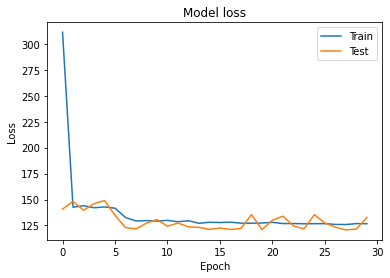

In [35]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test']) 
plt.show()

In [36]:
 model.save("model_nn_1.h5")
#keras.models.load_model()

In [24]:
model.evaluate(X_test_sc, Y_test)

471/471 [==============================] - 1s 1ms/step - loss: 133.1322 - mse: 133.1322


[133.13223266601562, 133.13223266601562]

In [25]:
pred = model.predict(X_test_sc).reshape((-1,))

In [26]:
def mape(y_test, y_pred):
  y_test, y_pred = np.array(y_test), np.array(y_pred)
  return np.mean(np.abs(y_test-y_pred)/y_test)

def print_scores(name, x, y):
  print('%s:\t MSE: %.2f, R^2 Score: %.2f, MAPE: %.4f' % (name, mean_squared_error(x, y),r2_score(x, y), mape(x, y)))

In [27]:
obser = Y_test.DTSM
resid = obser - pred
residsq = resid**2

dtco = X_train

mean_res = np.mean(resid)
stdv_res = np.std(resid)

print("Residual mean:", mean_res)
print("Residual stdv:", stdv_res)
print_scores('Test',Y_test.DTSM, pred)

Residual mean: -2.0971234992369596
Residual stdv: 11.346111554157535
Test:	 MSE: 133.13, R^2 Score: 0.89, MAPE: 0.0584


In [28]:
idx = np.random.choice(np.arange(len(pred)), 2000, replace=False)
resid_sample = resid.to_numpy()[idx]
#resid_psample = resid_p[idx]
residsq_sample = residsq.to_numpy()[idx]
pred_sample = pred[idx]
obser_sample = obser.to_numpy()[idx]

pred_sort, resid_sort, residsq_sort, obser_sort = zip(*sorted(zip(pred_sample, resid_sample,residsq_sample, obser_sample)))
resid_sm = lowess(resid_sort,pred_sort, frac=0.4)[:,1]
residsq_sm = lowess(residsq_sort,pred_sort, frac=0.4)[:,1]
obser_sm = lowess(obser_sort,pred_sort, frac=0.4)[:,1]

In [29]:
def cm_wh(cmp_name):
  cmp = cm.get_cmap(cmp_name, 256)
  newcm = cmp(np.linspace(0, 1, 256))
  newcm[0, :] = np.array([1, 1, 1, 1])
  return ListedColormap(newcm)

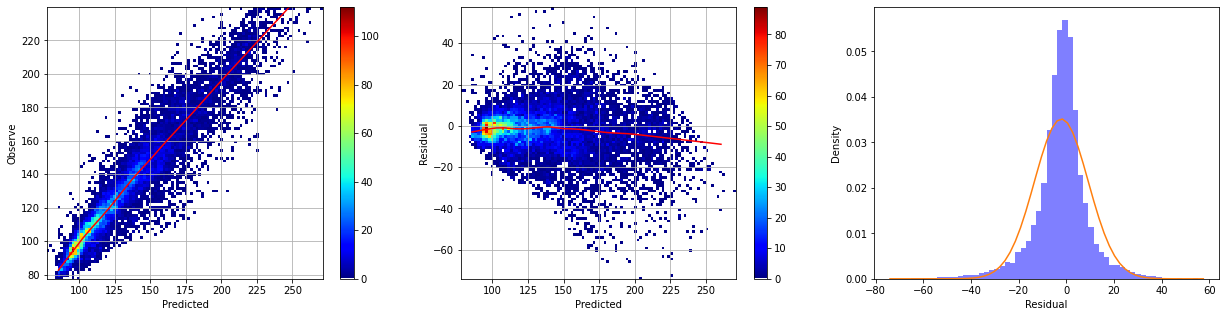

In [30]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(21,5))

h1=ax1.hist2d(pred, obser,bins=100, cmap=cm_wh('jet'))
ax1.plot(pred_sort, obser_sm, color='red')
#ax1.plot(x1, x1, color='black')
#ax1.axline([0, 0], [1, 1], color='white')
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Observe")
ax1.grid()
fig.colorbar(h1[3], ax=ax1)


h2=ax2.hist2d(pred, resid,bins=100, cmap=cm_wh('jet'))
ax2.plot(pred_sort, resid_sm, color='red')
ax2.set_xlabel("Predicted")
ax2.set_ylabel("Residual")
ax2.grid()
fig.colorbar(h2[3], ax=ax2)


n, bins, patches = ax3.hist(resid, 60, density=True, facecolor='blue', alpha=0.5)
ax3.plot(bins, norm.pdf(bins, mean_res, stdv_res))
ax3.set_xlabel("Residual")
ax3.set_ylabel("Density")


plt.show()

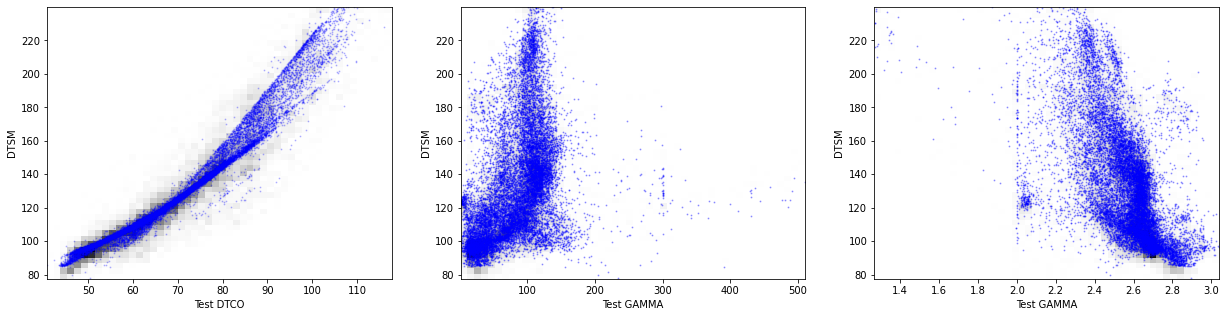

In [34]:
f, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(21,5))

#ax1.pcolormesh(X_tr, Y_tr, H_tr,cmap='binary')

ax1.hist2d(X_test.DTCO,Y_test.DTSM,bins=50, cmap='binary')
ax1.scatter(X_test.DTCO, pred, s=1, color='blue', alpha=0.2)
ax1.set_xlabel("Test DTCO")
ax1.set_ylabel("DTSM")


ax2.hist2d(X_test.GAMMA,Y_test.DTSM,bins=50, cmap='binary')
#ax2.hist2d(X_test.GAMMA,pred,bins=50, cmap=cm_wh('jet'), alpha=0.3)
ax2.scatter(X_test.GAMMA, pred, s=1, color='blue', alpha=0.3)
ax2.set_xlabel("Test GAMMA")
ax2.set_ylabel("DTSM")

ax3.hist2d(X_test.RHO,Y_test.DTSM,bins=50, cmap='binary')
ax3.scatter(X_test.RHO, pred, s=1, color='blue', alpha=0.3)
ax3.set_xlabel("Test GAMMA")
ax3.set_ylabel("DTSM");

## Reference
[1] 
https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb

[2]
https://keras-team.github.io/keras-tuner/

[3]
https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/




